In [21]:
#!pip3 install -e .
import numpy as np
import matplotlib.pyplot as plt
from astropy import convolution
from astropy.io import fits
import astropy
from scipy import signal
from fit_ring import fit_ring

In [22]:
hdulist = fits.open("../obs/hd163296_band6.fits")
wavelength = 0.125
NCUT = 1000
#hdulist = fits.open("../data/hd163296_band4.fits")
#wavelengthcm = 0.2054#299792458e2 　1.459500000000E+11 Hz
# NCUT = 0

# choose data range to fit
r_range = [60.0, 75.0]
limit_theta = False

### Fitting Parameters ###
# ring center of observed image
xcen, ycen = 0.0, 0.0

ring_r0 = 67.0
ring_tau = 1.0
ring_w = 4.0
ring_h = 4.0
temperature_t0 = 20.0
temperature_r0 = 50.0
temperature_pow = -0.5

In [23]:
# distance
dis = 101.0 # pc
# disk geomertry
incl = 46.7/180*np.pi # inclination in degree
posang = 133.1/180*np.pi # position angle in degree
posang_proj = posang + np.pi/2

# read fits data
pic = hdulist[0]
header = pic.header
image = pic.data[0,0]
image = image[NCUT:-NCUT,NCUT:-NCUT]

# check pixcel of figure
NAXIS1 = header['NAXIS1'] - NCUT*2
NAXIS2 = header['NAXIS2'] - NCUT*2
# check range (sec) per pixcel
CDELT1 = header['CDELT1']*3600
CDELT2 = header['CDELT2']*3600
CDELT1 = abs(CDELT1)
CDELT2 = abs(CDELT2)
BMAJ = header['BMAJ']*3600
BMIN = header['BMIN']*3600
BPA = header['BPA']

# Band 6 frequency: 233.0 GHz
freqGHz = 30/wavelength
image = 1.222e6 * image/BMAJ/BMIN/freqGHz**2

CDELT1 = CDELT1 * dis
CDELT2 = CDELT2 * dis
BMAJ = BMAJ * dis
BMIN = BMIN * dis

In [24]:
# smooth B6 image
# bmaj_obs_ker, bmin_obs_ker, bpa_obs_ker = # in au
#beam_kernel = convolution.Gaussian2DKernel(BMIN/2.355/CDELT2, BMAJ/2.355/CDELT1, theta=BPA/180*np.pi).array
# #image = convolution.convolve_fft(image, beam_kernel)
#image = signal.fftconvolve(image, beam_kernel, mode="same") # fastest

In [25]:
import scipy.interpolate as interpolate
# convert to radian
def deproject_image(image, incl_rad, pa_rad, nx0, ny0):
    ny, nx = image.shape
    # create coordinate system
    x = np.arange(nx)
    y = np.arange(ny)
    xx, yy = np.meshgrid(x, y, indexing="xy")
    # deproject
    dxx1 =  (xx-nx0)*np.cos(pa_rad) + (yy-ny0)*np.sin(pa_rad)
    dyy1 = -(xx-nx0)*np.sin(pa_rad) + (yy-ny0)*np.cos(pa_rad)
    dyy1 = dyy1 * np.cos(incl_rad)
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + nx0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + ny0

    # interpolate image
    f = interpolate.RectBivariateSpline(np.arange(nx), np.arange(ny), image.T)
    image_deprojected = f.ev(xx2, yy2)
    return image_deprojected

# deproject all images
image_deproj = deproject_image(image, incl, posang_proj, (NAXIS1-1)/2, (NAXIS2-1)/2)

In [26]:
# make grid
x_obs = np.linspace(-(NAXIS1-1)*CDELT1/2, (NAXIS1-1)*CDELT1/2, NAXIS1)
y_obs = np.linspace(-(NAXIS2-1)*CDELT2/2, (NAXIS2-1)*CDELT2/2, NAXIS2)
xx_obs, yy_obs = np.meshgrid(x_obs, y_obs, indexing='xy')

BMAJ_smooth = BMAJ
BMIN_smooth = BMIN
BPA_smooth = BPA
B_ave_smooth = np.sqrt(BMAJ_smooth*BMIN_smooth)

n_temp = int(r_range[1]/B_ave_smooth)
x_data_point = np.arange(-n_temp, n_temp+1) * B_ave_smooth
y_data_point = np.arange(-n_temp, n_temp+1) * B_ave_smooth
xx_data_point, yy_data_point = np.meshgrid(x_data_point, y_data_point, indexing='xy')
xx_data_point = xx_data_point.flatten()
yy_data_point = yy_data_point.flatten()

rr_data_point = np.sqrt(xx_data_point**2 + yy_data_point**2)
theta_data_point = np.arctan2(yy_data_point, xx_data_point)

# choose data points to fit
xx_data_point = xx_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
yy_data_point = yy_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
if (limit_theta):
    xx_data_point, yy_data_point = xx_data_point[(xx_data_point>0) | (yy_data_point>0)], yy_data_point[(xx_data_point>0) | (yy_data_point>0)]



In [27]:
x_model = np.linspace(-100, 100, 201)
y_model = np.linspace(-100, 100, 201)
xx_model, yy_model  = np.meshgrid(x_model, y_model, indexing="xy")

bmaj_model = BMAJ_smooth
bmin_model = BMIN_smooth
bpa_model = BPA_smooth
dx = x_model[1] - x_model[0]
dy = y_model[1] - y_model[0]
bmaj_model_n = bmaj_model / dx
bmin_model_n = bmin_model / dx

beam_kernel = convolution.Gaussian2DKernel(bmin_model_n/2.35, bmaj_model/2.35, bpa_model).array



In [28]:
### Fitting Parameters ###
# ring center of observed image
xcen, ycen = 0, 0

ring_r0 = 67.0
ring_tau = 1.0
ring_w = 4.0
ring_h = 4.0
temperature_t0 = 20.0
temperature_r0 = 50.0
temperature_pow = -0.5


# the most important part for mcmc fitting
xx_data_point_cen = xx_data_point + xcen
yy_data_point_cen = yy_data_point + ycen
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image_deproj.T, xx_data_point_cen, yy_data_point_cen)

intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model, yy_model)
intensity_conv = fit_ring.convolution(intensity, beam_kernel)
model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)

chi2 = np.sum((obs_data_points - model_data_points)**2)




In [29]:
chi2/obs_data_points.size

5.780210438134427

(-80.86362912619882, 80.86362912619882, -80.86362912619882, 80.86362912619882)

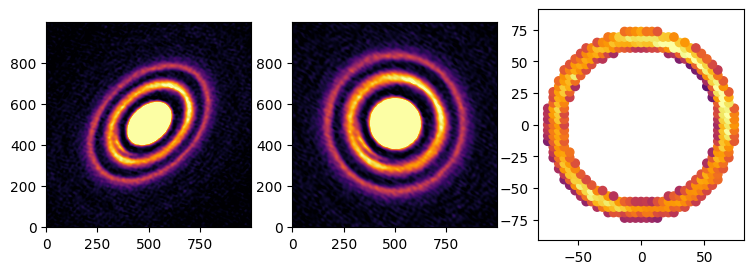

In [30]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(131)
ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax2 = fig.add_subplot(132)
ax2.imshow(image_deproj, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax3 = fig.add_subplot(133)
ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax3.axis('equal')